# Assignment Week 4-1: Deep Learning Framework (Model Training and Evaluation)

Created by: **Nghi Huynh**

This notebook is inspired by this [Brain tumor detection]( https://www.kaggle.com/code/ruslankl/brain-tumor-detection-v1-0-cnn-vgg-16) notebook

**Overview:** 

Deep Learning basic framework:

1. Dataset
2. DataLoader
3. Model
4. Training and evaluation

# Brain tumor detection

**Background:**
* Task description:
* Data description:

**Goal:** build a CNN model to detect brain tumor

**Methods:**

* EDA
* Data preprocessing
* Create Dataset
* Create DataLoader
* Training, validation and test splitting
* Data augmentation
* Pytorch CNN Model (baseline model vs ResNet9)
* Define optimizer, and loss function
* Training and evaluation
* Model performance
* Visualize predictions

**Conclusion:**

## Import libraries and packages

In [142]:
# Data preprocessing
import sys
import os
import numpy as np
import pandas as pd
import copy
import glob
import random
import time
from tqdm import tqdm
import shutil
import imutils


# Data visualization
from skimage import io
import cv2
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid import ImageGrid
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools
import seaborn as sns


plt.style.use("default")

In [143]:
# Data Loader and Model Building
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# Data Augmentation
import albumentations as A
from albumentations.pytorch import ToTensor

# Data splitting
from sklearn.model_selection import train_test_split

In [144]:
# Need to check if cuda is avaiable, to shift tensors and network to GPUs
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

In [145]:
device

device(type='cpu')

## Data preparation

### Download dataset

In [146]:
!git clone https://github.com/nghi-huynh/McMedHacks2022_W4-1_Pytorch_DL_framework.git

fatal: destination path 'McMedHacks2022_W4-1_Pytorch_DL_framework' already exists and is not an empty directory.


### Data splitting

Since all images are either in folder `yes` or `no` subfolders. We want to split the data into `train`, `val`, and `test` folders with the following proportions 70%-15%-15%, respectively.

In [147]:
!apt-get install tree

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tree is already the newest version (1.7.0-5).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [73]:
#!rm -r TRAIN TEST VAL

In [148]:
# Create new folders to store train, test, validation data
!mkdir TRAIN TEST VAL TRAIN/YES TRAIN/NO TEST/YES TEST/NO VAL/YES VAL/NO

mkdir: cannot create directory ‘TRAIN’: File exists
mkdir: cannot create directory ‘TEST’: File exists
mkdir: cannot create directory ‘VAL’: File exists
mkdir: cannot create directory ‘TRAIN/YES’: File exists
mkdir: cannot create directory ‘TRAIN/NO’: File exists
mkdir: cannot create directory ‘TEST/YES’: File exists
mkdir: cannot create directory ‘TEST/NO’: File exists
mkdir: cannot create directory ‘VAL/YES’: File exists
mkdir: cannot create directory ‘VAL/NO’: File exists


In [75]:
!tree -d 

.
├── McMedHacks2022_W4-1_Pytorch_DL_framework
│   └── brain_tumor_dataset
│       ├── no
│       └── yes
├── sample_data
├── TEST
│   ├── NO
│   └── YES
├── TRAIN
│   ├── NO
│   └── YES
└── VAL
    ├── NO
    └── YES

14 directories


In [76]:
# train 70%, val 15%, test 15%
IMG_PATH = '/content/McMedHacks2022_W4-1_Pytorch_DL_framework/brain_tumor_dataset/'
# split the data by train/val/test
for CLASS in os.listdir(IMG_PATH):
    if not CLASS.startswith('.'):
        IMG_NUM = len(os.listdir(IMG_PATH + CLASS))
        for (n, FILE_NAME) in enumerate(os.listdir(IMG_PATH + CLASS)):
            img = IMG_PATH + CLASS + '/' + FILE_NAME
            if n < 0.15*IMG_NUM:
                shutil.copy(img, 'TEST/' + CLASS.upper() + '/' + FILE_NAME)
            elif n < 0.85*IMG_NUM:
                shutil.copy(img, 'TRAIN/'+ CLASS.upper() + '/' + FILE_NAME)
            else: 
                shutil.copy(img, 'VAL/'+ CLASS.upper() + '/' + FILE_NAME)

## EDA

### Data distribution

Let's look at the distribution of classes among sets

In [78]:
def load_data(dir_path, img_size=(224,224)):
    """
    Load resized images as np.arrays to workspace
    """
    X = []
    y = []
    i = 0
    labels = dict()
    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(dir_path + path):
                if not file.startswith('.'):
                    img = cv2.imread(dir_path + path + '/' + file)
                    X.append(img)
                    y.append(i)
            i += 1
    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y, labels

In [79]:
TRAIN_DIR = 'TRAIN/'
TEST_DIR = 'TEST/'
VAL_DIR = 'VAL/'
IMG_SIZE = (224,224)

# use predefined function to load the image data into workspace
X_train, y_train, labels = load_data(TRAIN_DIR, IMG_SIZE)
X_test, y_test, _ = load_data(TEST_DIR, IMG_SIZE)
X_val, y_val, _ = load_data(VAL_DIR, IMG_SIZE)

100%|██████████| 2/2 [00:00<00:00,  3.68it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


177 images loaded from TRAIN/ directory.


100%|██████████| 2/2 [00:00<00:00, 18.67it/s]


39 images loaded from TEST/ directory.


100%|██████████| 2/2 [00:00<00:00, 14.16it/s]

37 images loaded from VAL/ directory.


In [80]:
y = dict()
y[0] = []
y[1] = []
for set_name in (y_train, y_val, y_test):
    y[0].append(np.sum(set_name == 0))
    y[1].append(np.sum(set_name == 1))

In [113]:
trace0 = go.Bar(
    x=['Train', 'Validation', 'Test'],
    y=y[0],
    text=y[0],
    name='No',
    marker=dict(color='#ABEBC6'),
    opacity=0.9,
)

trace1 = go.Bar(
    x=['Train', 'Validation', 'Test'],
    y=y[1],
    name='Yes',
    text=y[1],
    marker=dict(color='#C39BD3'),
    opacity=0.9,
)

data = [trace0, trace1]
layout = go.Layout(
    title={'text':'Count of classes in each set',
           'y':0.95,
           'x':0.5,
           'xanchor': 'center',
           'yanchor': 'top'
    },
    xaxis={'title': 'Set'},
    yaxis={'title': 'Count'},
    template='seaborn'
)
fig = go.Figure(data, layout)
iplot(fig)

### Data visualization

In [127]:
# note that you should choose any n that n%3 = 0 
# for this plot_samples to work 
def plot_samples(X, y, labels_dict, n=50):
    """
    Creates a gridplot for desired number of images (n) from the specified set
    """
    for index in range(len(labels_dict)):
        imgs = X[np.argwhere(y == index)][:n]
        j = 3
        i = int(n/j)

        plt.figure(figsize=(15,9))
        c = 1
        for img in imgs:
            plt.subplot(i,j,c)
            plt.imshow(img[0])

            plt.title(f'Image shape: {img[0].shape}')

            plt.xticks([])
            plt.yticks([])

            c += 1
        plt.suptitle('Tumor: {}'.format(labels_dict[index]))
        plt.show()

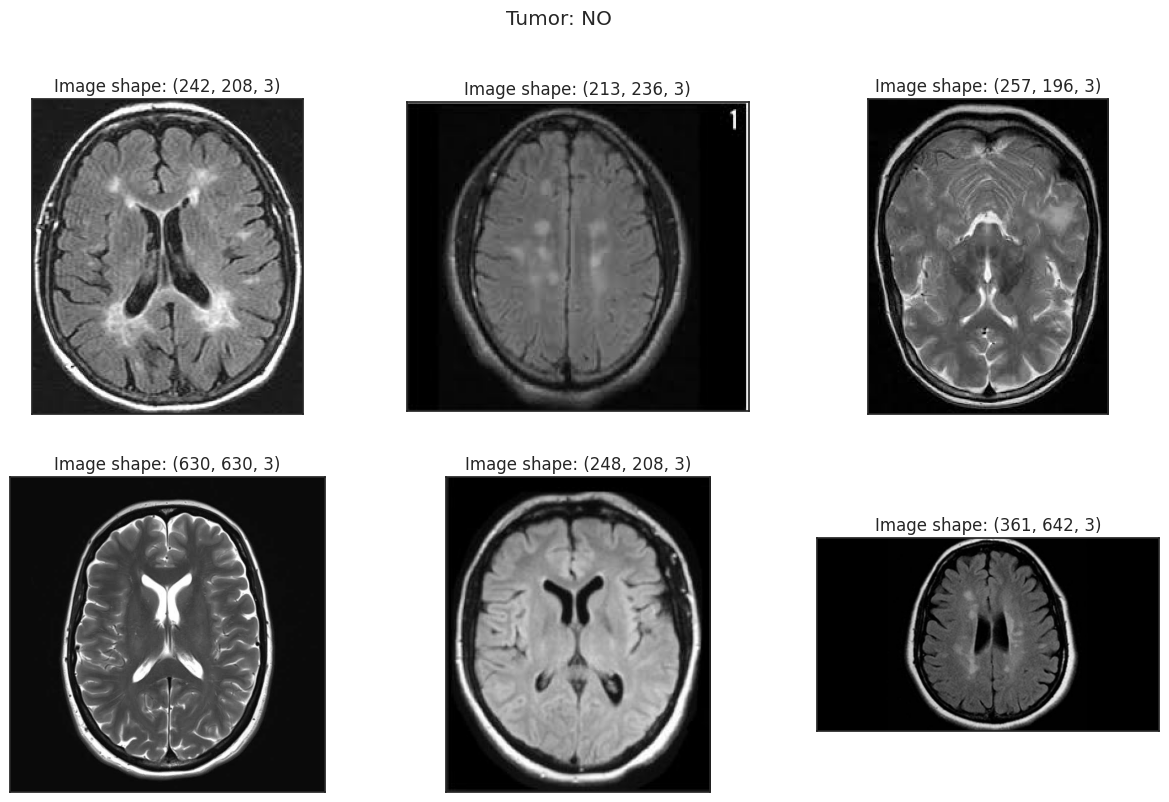

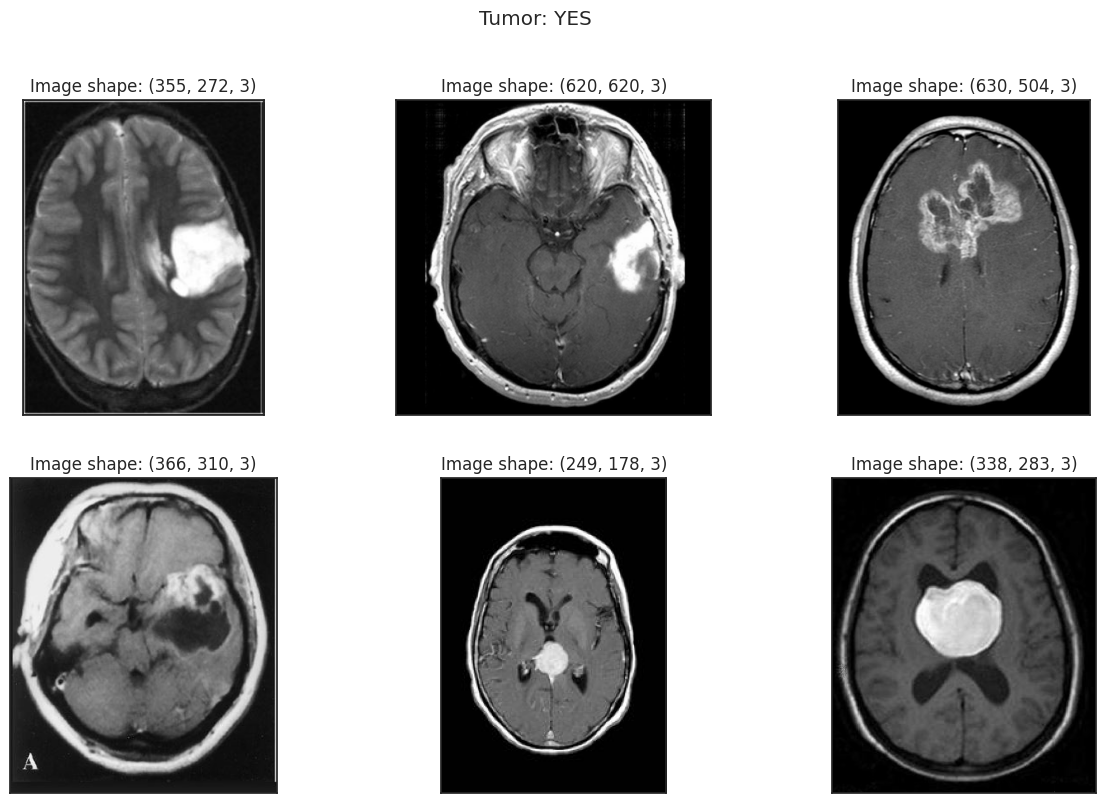

In [128]:
plot_samples(X_train, y_train, labels, 6)

We can see that all images have 3 color channels but different `height` and `width`. 

**Note:** all images must be of the same shape to feed into a CNN model. So, we will do some data preprocessing to prepare the correct input for our model

## Data preprocessing

### Normalization

We want to crop the brain out of the image. To do that, we need to find the extreme points on the image and crop the rectangular out of them. 

You can read more about this technique in this [pyimagesearch](https://pyimagesearch.com/2016/04/11/finding-extreme-points-in-contours-with-opencv/) blog

In [150]:
def crop_imgs(set_name, add_pixels_value=0, img_size=(224,224)):
    """
    Finds the extreme points on the image and crops the rectangular out of them
    """
    set_new = []
    for img in set_name:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        gray = cv2.GaussianBlur(gray, (5, 5), 0)

        # threshold the image, then perform a series of erosions +
        # dilations to remove any small regions of noise
        thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)

        # find contours in thresholded image, then grab the largest one
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        c = max(cnts, key=cv2.contourArea)

        # find the extreme points
        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])

        ADD_PIXELS = add_pixels_value
        normalized_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
        new_img = cv2.resize(normalized_img, dsize=img_size)
        set_new.append(new_img)

    return np.array(set_new)

In [151]:
# apply this for each set
X_train_crop = crop_imgs(set_name=X_train)
X_val_crop = crop_imgs(set_name=X_val)
X_test_crop = crop_imgs(set_name=X_test)

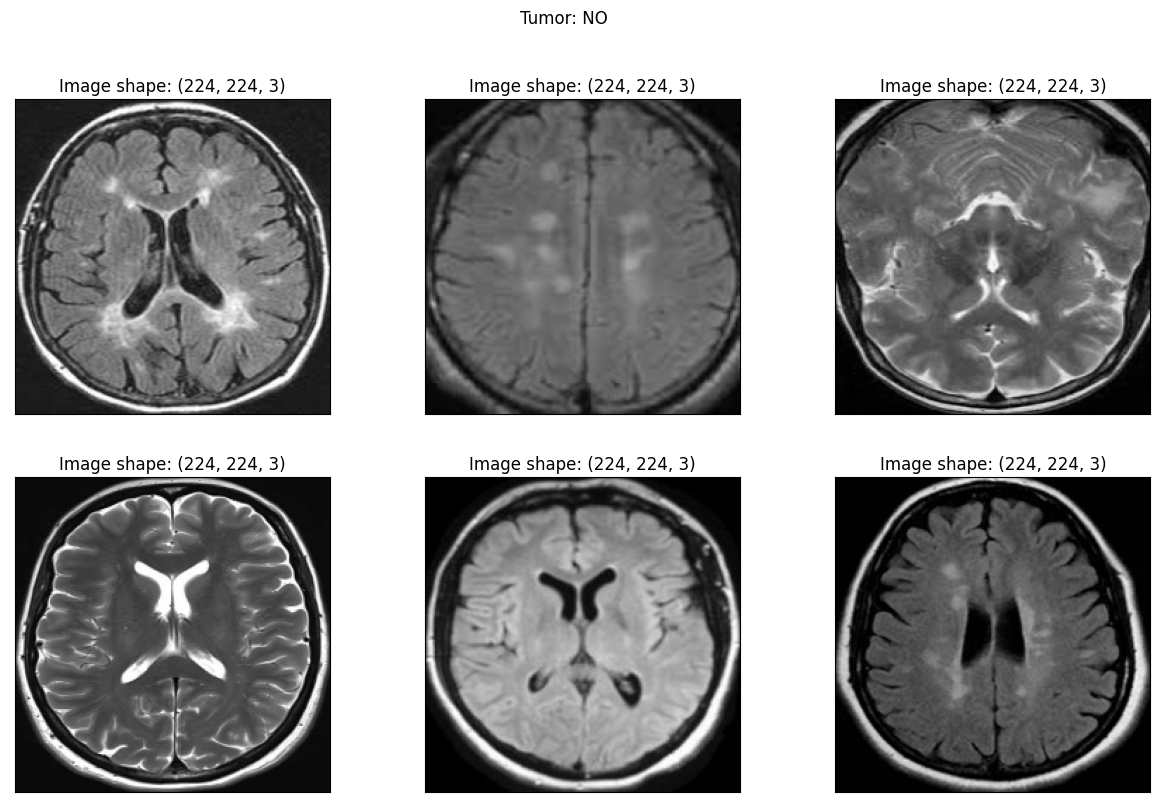

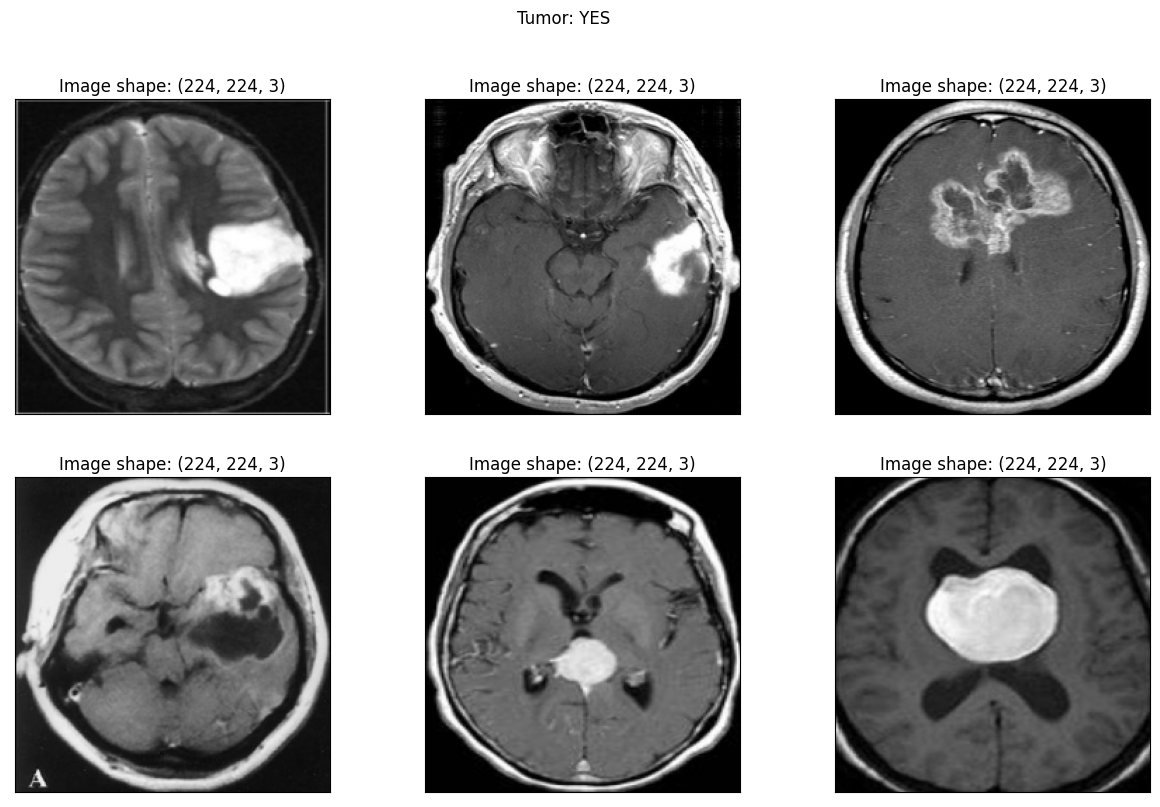

In [152]:
# let's double check if our images are normalized correctly
plot_samples(X_train_crop, y_train, labels, 6)

In [157]:
def save_new_images(x_set, y_set, folder_name):
    i = 0
    for (img, imclass) in zip(x_set, y_set):
        if imclass == 0:
            cv2.imwrite(folder_name+'no/'+str(i)+'.jpg', img)
        else:
            cv2.imwrite(folder_name+'yes/'+str(i)+'.jpg', img)
        i += 1

In [ ]:
# saving new images to the folder

!mkdir BrainTumor_Preprocessed_Data BrainTumor_Preprocessed_Data/train BrainTumor_Preprocessed_Data/test BrainTumor_Preprocessed_Data/val BrainTumor_Preprocessed_Data/train/yes BrainTumor_Preprocessed_Data/train/no BrainTumor_Preprocessed_Data/test/yes BrainTumor_Preprocessed_Data/test/no BrainTumor_Preprocessed_Data/val/yes BrainTumor_Preprocessed_Data/val/no


In [158]:
save_new_images(X_train_crop, y_train, folder_name='BrainTumor_Preprocessed_Data/train/')
save_new_images(X_val_crop, y_val, folder_name='BrainTumor_Preprocessed_Data/val/')
save_new_images(X_test_crop, y_test, folder_name='BrainTumor_Preprocessed_Data/test/')

In [156]:
!tree -d

.
├── BrainTumor_Preprocessed_Data
│   ├── test
│   │   ├── no
│   │   └── yes
│   ├── train
│   │   ├── no
│   │   └── yes
│   └── val
│       ├── no
│       └── yes
├── McMedHacks2022_W4-1_Pytorch_DL_framework
│   └── brain_tumor_dataset
│       ├── no
│       └── yes
├── sample_data
├── TEST
│   ├── NO
│   └── YES
├── TRAIN
│   ├── NO
│   └── YES
└── VAL
    ├── NO
    └── YES

24 directories


Now that we have normalized and resized images in the new folders. We can start our **assignment**!